In [1]:
# %tensorflow_version 1.x
# !pip install stable-baselines[mpi]==2.10.0

!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (930 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking 

In [2]:
import gym
import numpy as np
from gym import spaces
from gym.utils import seeding
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
initial_mu_values = [-60, -20, 20, 60]
memory_len = 8
class fourarmedbandit(gym.Env):
    def __init__(self, trend = True, high = False, seed=0):
        self.set_seed(seed)
        
        super(fourarmedbandit, self).__init__()
        
        self.trend = trend
        self.high = high
        self.e = 0
        self.trend_val = 0.5*np.array([1, 1, -1, -1])
        reward = np.zeros(4)
        self.lamda = 0.999
        self.sigma_ex = 2
        self.unex_high = 16
        self.unex_low = 4
        reward[0] = initial_mu_values[0]
        reward[1] = initial_mu_values[1]
        reward[2] = initial_mu_values[2]
        reward[3] = initial_mu_values[3]
        self.reward_space = reward
        self.length = 4
        self.action_space = spaces.Discrete(self.length,)
        self.observation_space = spaces.Box(low=-np.inf, 
                                     high=np.inf, shape = (4,memory_len), dtype=np.float32)
        self.score = 0
        self.length = 4
        self.agent_position = 4
        self.state = np.zeros((4,memory_len))
        self.optm = 3

        self.episode_reward_history = []
        self.reward_history = []

        self.episode_optimal_history = []
        self.optimal_history = []
        self.rewards = np.zeros((4))

    def set_seed(self, seed = 0):
        np.random.seed(seed)
    
    def step(self, action, rend = False, rng = np.random.RandomState(1111)):
        reward = 0
        if rend:
            self.render(reward)

        self.rewards = rng.normal(self.reward_space, self.sigma_ex)
        reward = self.rewards[action]
        self.optm = np.max(self.rewards)
        optimal_action = np.argmax(self.rewards)
        self.score += reward
        if rend:
            self.render(reward, a = action)
        var = self.unex_low
        if ( self.high & (((self.e<=100) & (self.e>50)) | ((self.e<=200) & (self.e>150))) ):
            var = self.unex_high
        self.reward_space = self.lamda * self.reward_space + rng.normal(0, var, size = (4))
        if self.trend:
            self.reward_space += self.trend_val
        self.e += 1
        done = False
        self.episode_reward_history.append(reward)
        self.episode_optimal_history.append(self.optm)
        if self.e == 200:
            done = True
            self.reward_history.append(np.sum(self.episode_reward_history))
            self.optimal_history.append(np.sum(self.episode_optimal_history))
            self.episode_reward_history = []
            self.episode_optimal_history = []

        temp = self.state[action].tolist()
        temp.pop(0)
        temp.append(reward)
        self.state[action] = np.array(temp)

        # print(f'  Step: {self.e} || Reward: {reward} || Action: {action} || Optimal: {optimal_action}')

        return self.state, reward, done, {}

    def reset(self):
        
        self.e = 0
        self.score = 0
        reward = np.zeros(4)
        reward[0] = initial_mu_values[0]
        reward[1] = initial_mu_values[1]
        reward[2] = initial_mu_values[2]
        reward[3] = initial_mu_values[3]
        self.reward_space = reward
        self.agent_position = 4
        self.state = np.zeros((4,memory_len))
        self.optm = 3
        return self.state

    def render(self, r, a = -1):
        pass
      

In [3]:
env1 = fourarmedbandit()
env2 = fourarmedbandit()
env2.__init__(high = True)
env3 = fourarmedbandit()
env3.__init__(trend = False)
env4 = fourarmedbandit()
env4.__init__(trend = False, high = True)

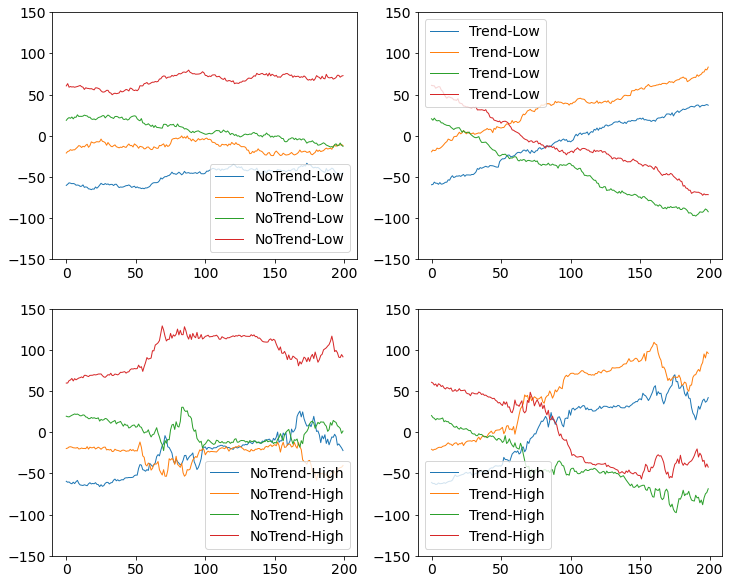

In [7]:
n_trials = 10
rew1 = np.zeros((n_trials, 200, 4))
rew2 = np.zeros((n_trials, 200, 4))
rew3 = np.zeros((n_trials, 200, 4))
rew4 = np.zeros((n_trials, 200, 4))
for k in range(n_trials):
    env1.set_seed(0)
    env2.set_seed(0)
    env3.set_seed(0)
    env4.set_seed(0)
    rng = np.random.RandomState(seed = 1220+k)
    for j in range(4):
        for i in range(200):
            _,rew1[k][i][j],_,_ = env1.step(j, rng=rng)
            _,rew2[k][i][j],_,_ = env2.step(j, rng=rng)
            _,rew3[k][i][j],_,_ = env3.step(j, rng=rng)
            _,rew4[k][i][j],_,_ = env4.step(j, rng=rng)
        env1.reset()
        env2.reset()
        env3.reset()
        env4.reset()
linewidth = 1
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': 14})
plt.subplot(2,2,2)
plt.plot(np.average(rew1, axis=0), label = 'Trend-Low', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.subplot(2,2,4)
plt.plot(np.average(rew2, axis=0), label = 'Trend-High', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.subplot(2,2,1)
plt.plot(np.average(rew3, axis=0), label = 'NoTrend-Low', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.subplot(2,2,3)
plt.plot(np.average(rew4, axis=0), label = 'NoTrend-High', linewidth=linewidth)
plt.ylim([-150, 150])
plt.legend()
plt.show()

In [11]:
# moving average function
def numpy_ewma_vectorized_v2(data, window):

  alpha = 2 /(window + 1.0)
  alpha_rev = 1-alpha
  n = data.shape[0]

  pows = alpha_rev**(np.arange(n+1))

  scale_arr = 1/pows[:-1]
  offset = data[0]*pows[1:]
  pw0 = alpha*alpha_rev**(n-1)

  mult = data*pw0*scale_arr
  cumsums = mult.cumsum()
  out = offset + cumsums*scale_arr[::-1]
  return out

# Case 1: DQN and PPO, env with trend=True and high=True

In [10]:
"""

Case 1: DQN env with trend=True and high=True

"""




from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
verbose = 0
episodes = 500
env_dqn1 = fourarmedbandit(seed=seed, trend = True, high=True)
env_dqn1.reset()
policy_kwargs = dict(net_arch=[400,300])
model1 = DQN('MlpPolicy', env_dqn1, verbose=verbose, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model1.learn(total_timesteps=int(200*episodes))
# Save the agent
model1.save("rmab")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


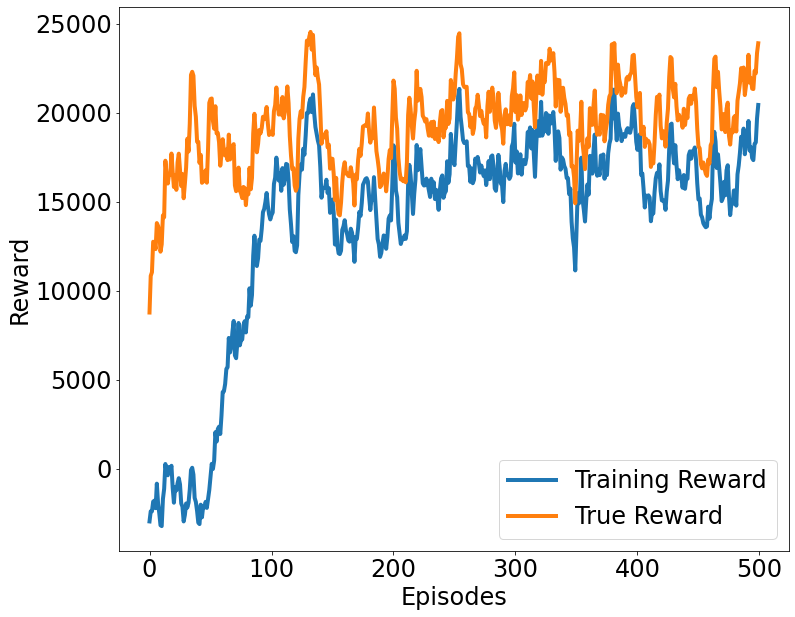

In [12]:

linewidth = 4
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn1.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn1.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with trend & high volatility")
# plt.title("DQN for trend and high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_trend_high.eps', format='eps')
plt.savefig('dqn_training_trend_high.jpg', dpi=300)
plt.show()

In [14]:
"""

Case 1: PPO env with trend=True and high=True

"""

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
episodes = 500
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env_ppo1 = fourarmedbandit(trend=True, high = True, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo1 = PPO("MlpPolicy", env_ppo1, verbose=0, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo1.learn(total_timesteps=200*episodes)
model_ppo1.save("ppo_rmab")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


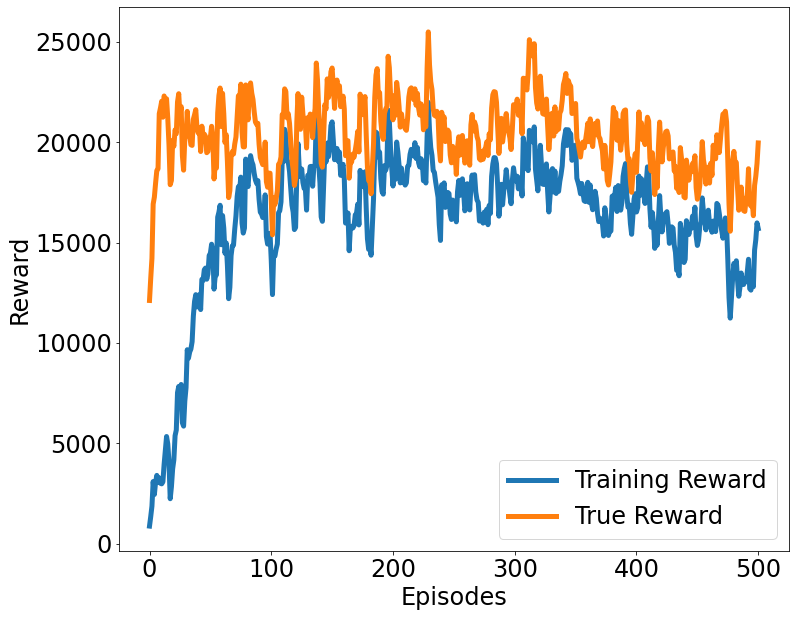

In [15]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo1.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo1.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for PPO on env with trend & high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_trend_high.eps', format='eps')
plt.savefig('ppo_training_trend_high.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


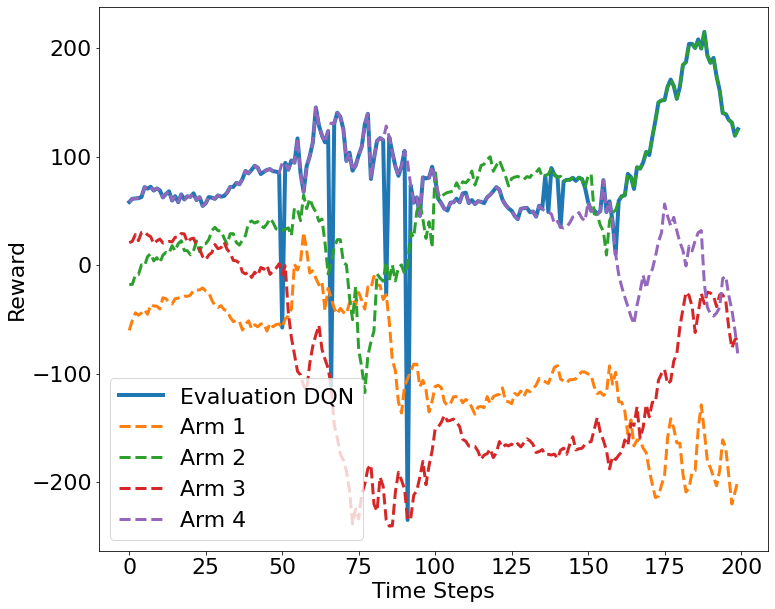

In [16]:
# Single game run for Case 1 with DQN

episodes = 1
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env1 = fourarmedbandit(trend=True, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env1.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model1.predict(obs)
      e = test_env1.e
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env1.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env1.step(action)
      rew[i][e][:] = test_env1.rewards
      optimal_reward[i][e] = test_env1.optm

linewidth = 4
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 22})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation DQN', linewidth=linewidth)
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
# plt.show()
# plt.figure(figsize=(8,6))
for i in range(4):
  plt.plot(np.mean(rew[:,:,i], axis = 0), '--', label='Arm '+str(i+1), linewidth=3)
plt.legend()
plt.savefig('1game_dqn_evaluation_trend_high.eps', format='eps')
plt.savefig('1game_dqn_evaluation_trend_high.jpg', dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


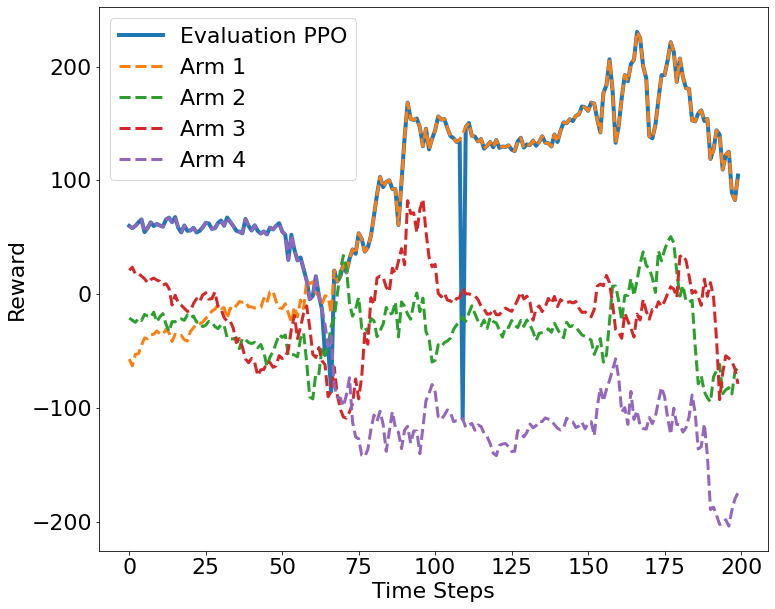

In [20]:
# Single game run for Case 1 with PPO

episodes = 1
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env1 = fourarmedbandit(trend=True, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env1.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model_ppo1.predict(obs)
      e = test_env1.e
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env1.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env1.step(action)
      rew[i][e][:] = test_env1.rewards
      optimal_reward[i][e] = test_env1.optm

linewidth = 4
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 22})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation PPO', linewidth=linewidth)
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
for i in range(4):
  plt.plot(np.mean(rew[:,:,i], axis = 0), '--', label='Arm '+str(i+1), linewidth=3)
plt.legend()
plt.savefig('1game_ppo_evaluation_trend_high.eps', format='eps')
plt.savefig('1game_ppo_evaluation_trend_high.jpg', dpi=300)
plt.show()

# Case 2: DQN and PPO, env with trend=True and high=False

In [21]:
"""

Case 2: DQN env with trend=True and high=False

"""
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
episodes = 500
env_dqn2 = fourarmedbandit(seed=seed, trend = True, high=False)
env_dqn2.reset()
policy_kwargs = dict(net_arch=[400,300])
model2 = DQN('MlpPolicy', env_dqn2, verbose=0, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model2.learn(total_timesteps=int(200*episodes))
# Save the agent
model2.save("rmab2")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


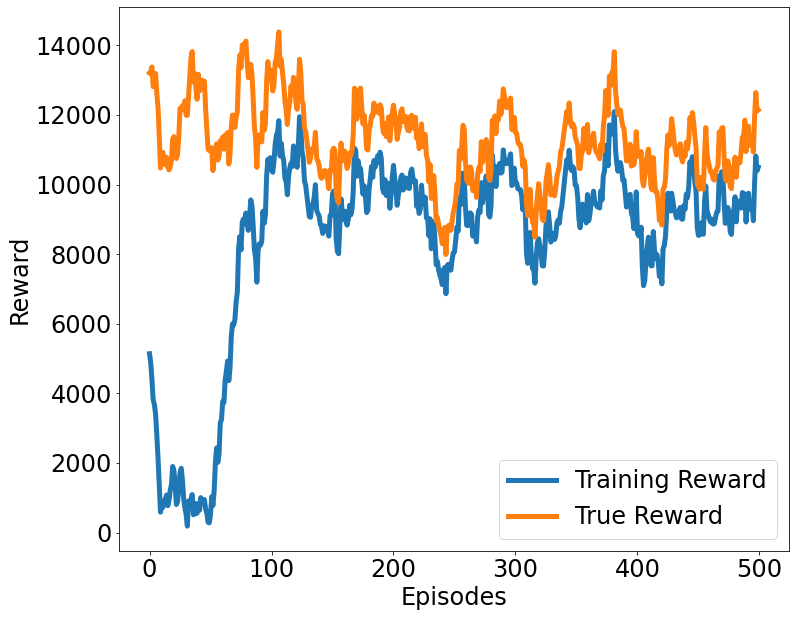

In [22]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn2.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn2.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with trend & low volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_trend_low.eps', format='eps')
plt.savefig('dqn_training_trend_low.jpg', dpi=300)
plt.show()

In [23]:
"""

Case 2: PPO env with trend=True and high=False

"""

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
episodes = 500
env_ppo2 = fourarmedbandit(trend=True, high = False, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo2 = PPO("MlpPolicy", env_ppo2, verbose=0, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo2.learn(total_timesteps=200*episodes)
model_ppo2.save("ppo_rmab2")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


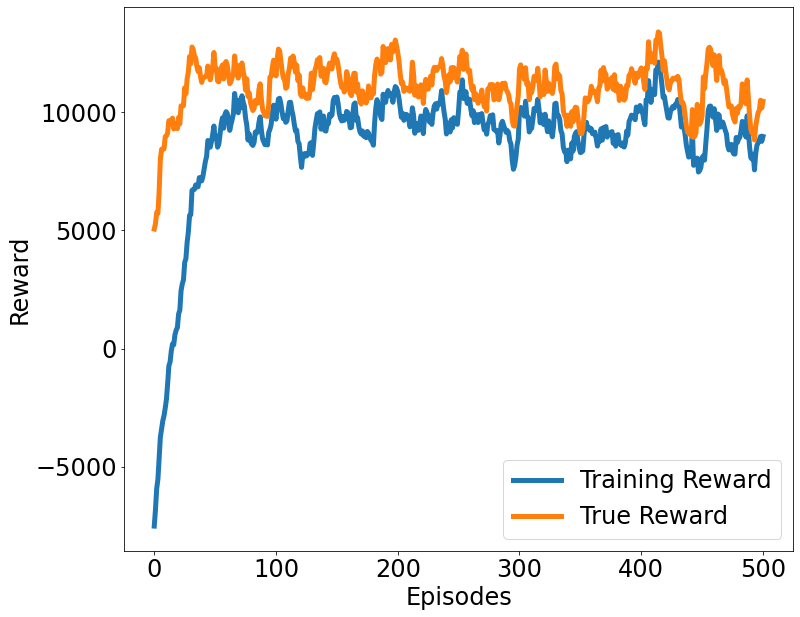

In [24]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo2.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo2.optimal_history), 20), label='True Reward', linewidth=linewidth)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_trend_low.eps', format='eps')
plt.savefig('ppo_training_trend_low.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


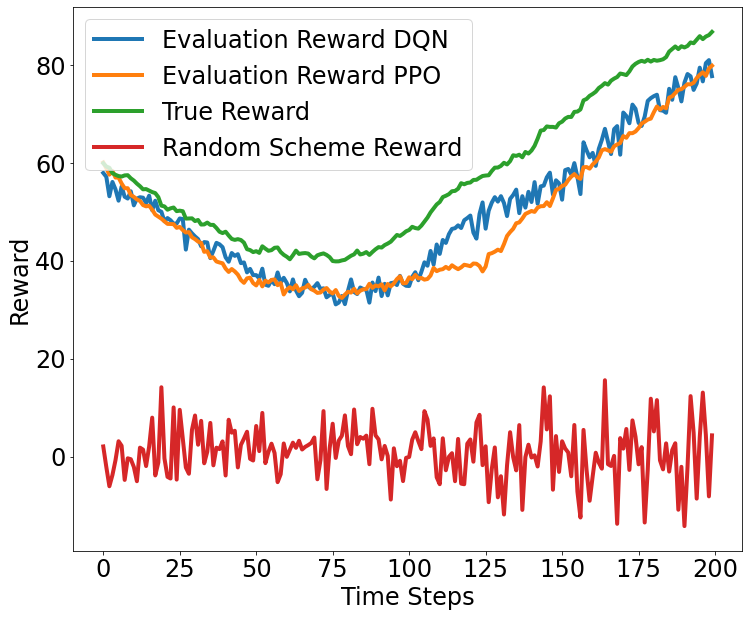

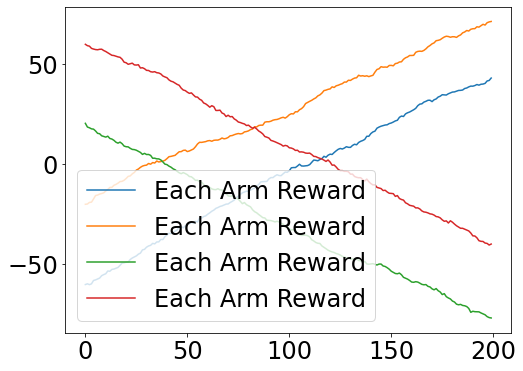

In [31]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env2 = fourarmedbandit(trend=True, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env2.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model2.predict(obs)
      e = test_env2.e
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env2.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env2.step(action)
      rew[i][e][:] = test_env2.rewards
      optimal_reward[i][e] = test_env2.optm
    
test_env2 = fourarmedbandit(trend=True, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env2.reset()
  dones = False
  # optim = 0
  while not dones:
      action, _states = model_ppo2.predict(obs)
      e = test_env2.e
      obs, rewards_ppo[i][e], dones, info = test_env2.step(action)
linewidth = 4
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward DQN', linewidth=linewidth)
plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation Reward PPO', linewidth=linewidth)
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme Reward', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with trend & low volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_ppo_evaluation_trend_low.eps', format='eps')
plt.savefig('dqn_ppo_evaluation_trend_low.jpg', dpi=300)
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

# Case 3: DQN and PPO, env with trend=False and high=True

In [33]:
"""

Case 3: DQN env with trend=False and high=True

"""
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
episodes = 500
env_dqn3 = fourarmedbandit(seed=seed, trend = False, high=True)
env_dqn3.reset()
policy_kwargs = dict(net_arch=[400,300])
model3 = DQN('MlpPolicy', env_dqn3, verbose=0, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model3.learn(total_timesteps=int(200*episodes))
# Save the agent
model3.save("rmab3")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


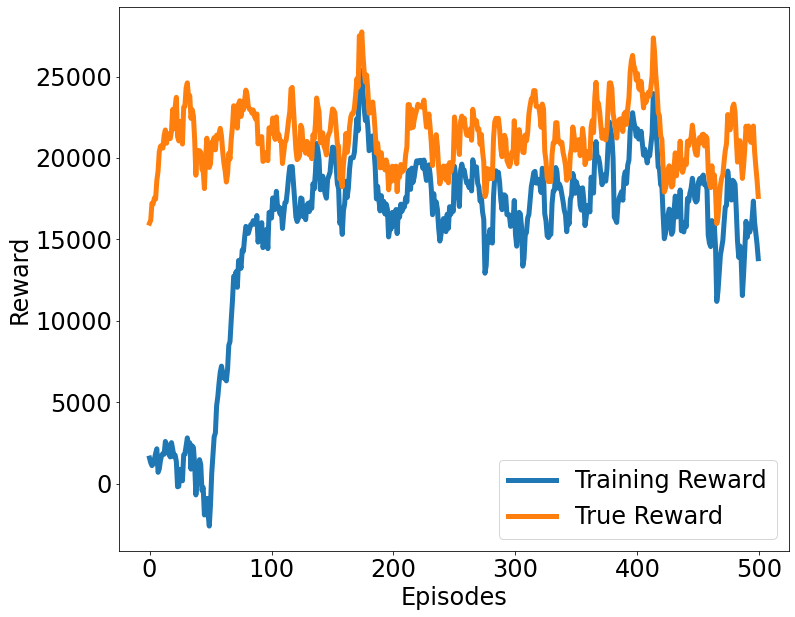

In [34]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn3.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn3.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with no trend & high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_notrend_high.eps', format='eps')
plt.savefig('dqn_training_notrend_high.jpg', dpi=300)
plt.show()

In [35]:
"""

Case 3: PPO env with trend=False and high=True

"""
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
episodes = 500
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env_ppo3 = fourarmedbandit(trend=False, high = True, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo3 = PPO("MlpPolicy", env_ppo3, verbose=0, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo3.learn(total_timesteps=200*episodes)
model_ppo3.save("ppo_rmab3")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


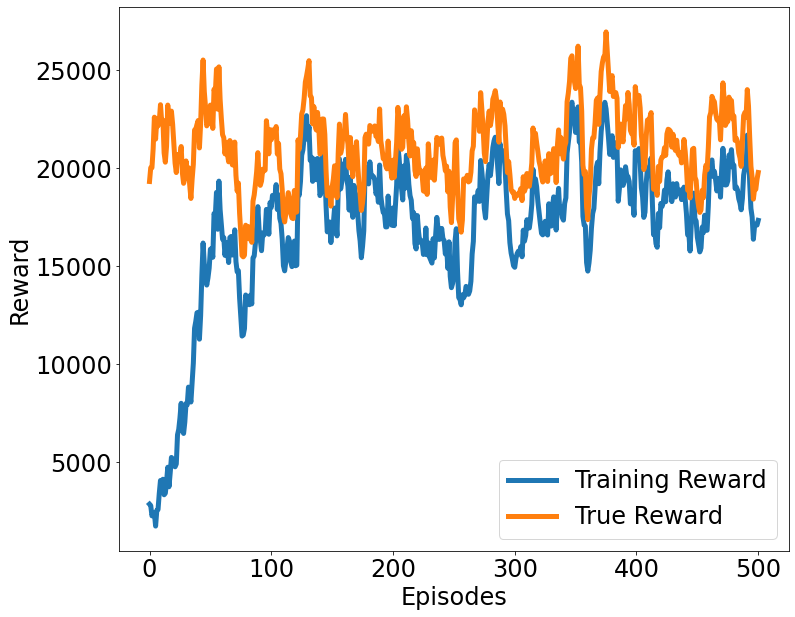

In [36]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo3.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo3.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for PPO on env with no trend & high volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_notrend_high.eps', format='eps')
plt.savefig('ppo_training_notrend_high.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


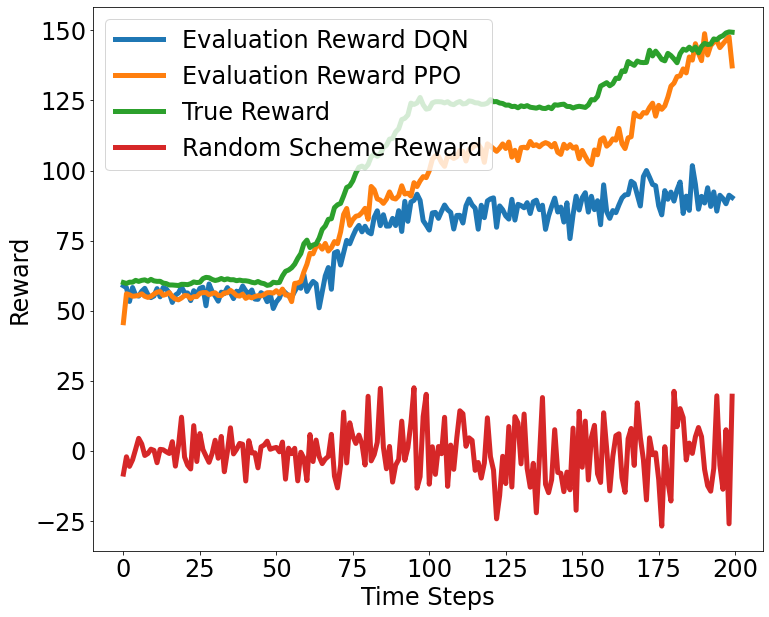

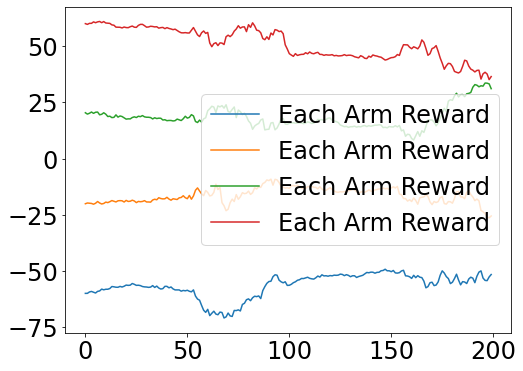

In [37]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env3 = fourarmedbandit(trend=False, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env3.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model3.predict(obs)
      e = test_env3.e
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env3.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env3.step(action)
      rew[i][e][:] = test_env3.rewards
      optimal_reward[i][e] = test_env3.optm
      
test_env3 = fourarmedbandit(trend=False, high=True, seed=0)
dones = False
for i in range(episodes):
  obs = test_env3.reset()
  dones = False
  # optim = 0
  while not dones:
      action, _states = model_ppo3.predict(obs)
      e = test_env3.e
      obs, rewards_ppo[i][e], dones, info = test_env3.step(action)
      
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward DQN', linewidth=linewidth)
plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation Reward PPO', linewidth=linewidth)
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme Reward', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with no trend & high volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_ppo_evaluation_notrend_high.eps', format='eps')
plt.savefig('dqn_ppo_evaluation_notrend_high.jpg', dpi=300)
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

# Case 4: DQN and PPO, env with trend=False and high=False

In [38]:
"""

Case 4: DQN env with trend=False and high=False

"""
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
gamma = 0
exploration_fraction = 0.2
exploration_initial_eps = 1.0
exploration_final_eps = 0.05
learning_rate = 0.01
buffer_size = 1000000
learning_starts = 10000
batch_size = 32
seed = 0
episodes = 500
env_dqn4 = fourarmedbandit(seed=seed, trend = False, high=False)
env_dqn4.reset()
policy_kwargs = dict(net_arch=[400,300])
model4 = DQN('MlpPolicy', env_dqn4, verbose=0, exploration_initial_eps=exploration_initial_eps, exploration_final_eps=exploration_final_eps, 
            exploration_fraction=exploration_fraction, gamma=gamma, learning_rate=learning_rate, 
            buffer_size=buffer_size, learning_starts=learning_starts, batch_size=batch_size, 
            seed = seed, target_update_interval=250, create_eval_env=True, policy_kwargs = policy_kwargs)
# Train the agent
model4.learn(total_timesteps=int(200*episodes))
# Save the agent
model4.save("rmab3")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


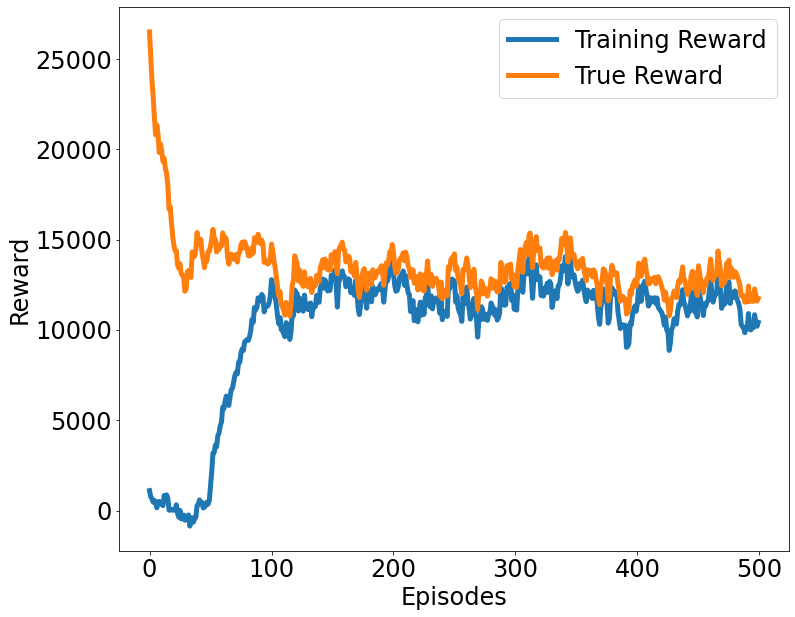

In [39]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn4.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_dqn4.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for DQN on env with no trend & low volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_training_notrend_low.eps', format='eps')
plt.savefig('dqn_training_notrend_low.jpg', dpi=300)
plt.show()

In [41]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
gamma = 0
learning_rate = 0.001
buffer_size = 1000000
batch_size = 32
seed = 0
episodes = 500
# Parallel environments
# env = make_vec_env(fourarmedbandit, n_envs=4)
env_ppo4 = fourarmedbandit(trend=False, high = False, seed=0)
policy_kwargs = dict(net_arch=[dict(pi=[400,300], vf=[400,300])])
model_ppo4 = PPO("MlpPolicy", env_ppo4, verbose=0, policy_kwargs=policy_kwargs, gamma = gamma, learning_rate=learning_rate,
            batch_size=batch_size, seed = seed)
model_ppo4.learn(total_timesteps=200*episodes)
model_ppo4.save("ppo_rmab3")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


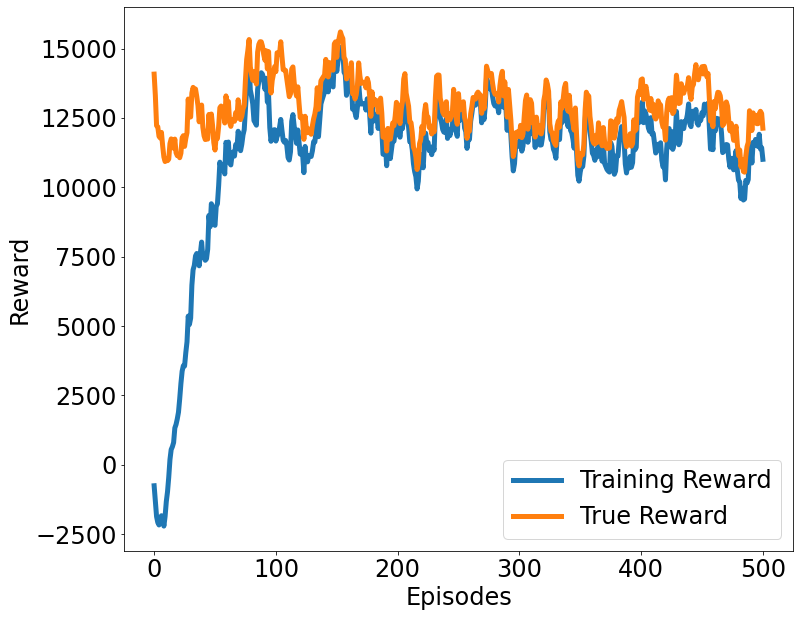

In [42]:
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo4.reward_history), 20), label='Training Reward', linewidth=linewidth)
plt.plot(numpy_ewma_vectorized_v2(np.array(env_ppo4.optimal_history), 20), label='True Reward', linewidth=linewidth)
# plt.title("Training reward for PPO on env with no trend & low volatility")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.savefig('ppo_training_notrend_low.eps', format='eps')
plt.savefig('ppo_training_notrend_low.jpg', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


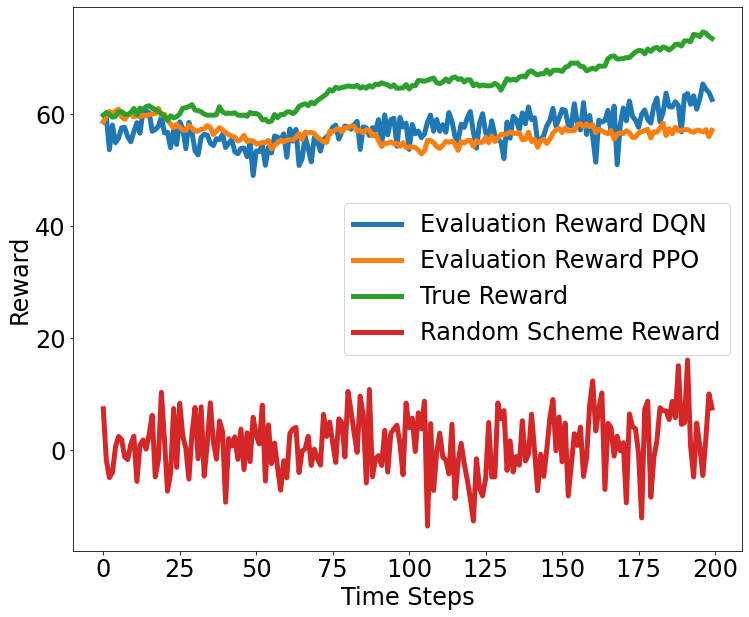

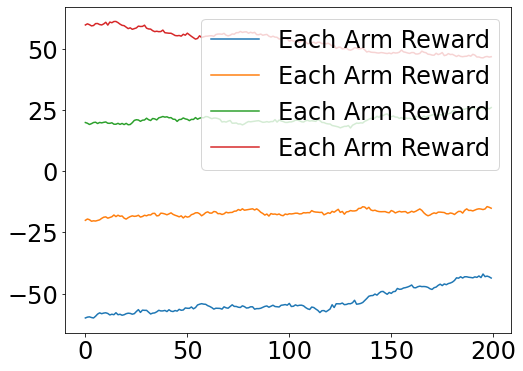

In [43]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
rewards_ppo = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
test_env4 = fourarmedbandit(trend=False, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env4.reset()
  dones = False
  optim = 0
  while not dones:
      action, _states = model4.predict(obs)
      e = test_env4.e
      random_action = np.random.choice(4)
      random_rewards[i][e] = test_env4.rewards[random_action]
      obs, rewards[i][e], dones, info = test_env4.step(action)
      rew[i][e][:] = test_env4.rewards
      optimal_reward[i][e] = test_env4.optm
      
test_env4 = fourarmedbandit(trend=False, high=False, seed=0)
dones = False
for i in range(episodes):
  obs = test_env4.reset()
  dones = False
  # optim = 0
  while not dones:
      action, _states = model_ppo4.predict(obs)
      e = test_env4.e
      obs, rewards_ppo[i][e], dones, info = test_env4.step(action)
linewidth = 5
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 24})
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward DQN', linewidth=linewidth)
plt.plot(np.mean(rewards_ppo, axis = 0), label='Evaluation Reward PPO', linewidth=linewidth)
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward', linewidth=linewidth)
plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme Reward', linewidth=linewidth)
# plt.title("Evaluation reward averaged over "+str(episodes)+" env with no trend & low volatility")
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.legend()
plt.savefig('dqn_ppo_evaluation_notrend_low.eps', format='eps')
plt.savefig('dqn_ppo_evaluation_notrend_low.jpg', dpi=300)
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))

# DQN implementation

In [44]:
import torch as T 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np
import gym 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [45]:
class DeepQNetwork(nn.Module): # every class that extends the functionality of a neural network derives from nn.Module, to get things like backprop and all
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims 
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims) # * means we can pass a list as in CNN like 3 rgb layers
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions


In [46]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, 
                max_mem_size = 100000, eps_end=0.01, eps_dec=5e-5):
        self.gamma = gamma
        self.epsilon = epsilon 
        self.eps_min = eps_end 
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0

        self.Q_eval = DeepQNetwork(lr = self.lr, n_actions=n_actions, input_dims = input_dims, 
                                    fc1_dims=400, fc2_dims=300)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        #find index of first unoccupied memory index
        index = self.mem_cntr % self.mem_size # wraps around
        self.state_memory[index] = state 
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.normal() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device).float() # need to turn observation into pytorch tensor and send it to the device
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        
        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return 
        
        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)
      
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch] # dereferncing to get values of the actions we actually took
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0] # [0] because it returns a (value, index) tuple
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

In [49]:
if __name__=='__main__':
    SEED = 0
    env = fourarmedbandit(seed=SEED, trend=True, high=True)
    # env._seed(SEED)
    eval_env = fourarmedbandit(seed=SEED, trend=True, high=True)
    # eval_env._seed(SEED)

    np.random.seed(SEED)
    T.manual_seed(SEED)

    agent = Agent(gamma=0, epsilon=1.0, batch_size=32, n_actions=4, 
                eps_end=0.01, input_dims=[4*memory_len], lr=0.01)
    scores, eps_history = [], []
    eval_scores = []
    optimal_training_scores = []
    optimal_evaluation_scores = []
    n_games = 250 

    # for i in range(n_games):
    for i in tqdm(range(n_games),ascii=True, unit="episode"):
        # if i==500:
        #   agent.epsilon = 1.0
        score = 0
        optimal_score = 0
        done = False 
        observation = env.reset()
        observation = observation.flatten()
        # observation = [float(i) for i in observation]
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            observation_ = observation_.flatten()
            score += reward 
            optimal_score += env.optm
            agent.store_transition(observation, action, reward, 
                            observation_, done)

            agent.learn()
            observation = observation_
        scores.append(score)
        optimal_training_scores.append(optimal_score)
        eps_history.append(agent.epsilon)
        avg_score = np.mean(scores[-100:])

        # print()
        # print('Training: ', 'episode ', i, 'optimal score %.2f' % optimal_score, 'score %.2f' % score, 
        #         'average score %.2f' % avg_score, 
        #         'epsilon %.2f' % agent.epsilon)

        # Evaluation
        eval_env.set_seed(SEED)
        # eval_env.__init__()
        observation = eval_env.reset()
        observation = observation.flatten()
        eval_score = 0
        optimal_score = 0
        done = False
        while not done:
          state = T.tensor([observation]).to(agent.Q_eval.device).float() # need to turn observation into pytorch tensor and send it to the device
          actions = agent.Q_eval.forward(state)
          action = T.argmax(actions).item()
          observation_, reward, done, info = eval_env.step(action)
          observation_ = observation_.flatten()
          eval_score += reward 
          optimal_score += eval_env.optm
          observation = observation_
        eval_scores.append(eval_score)
        optimal_evaluation_scores.append(optimal_score)
        avg_score = np.mean(eval_scores[-100:])
        # print('Evaluation: ', 'episode ', i, 'optimal score %.2f' % optimal_score, 'score %.2f' % eval_score, 
                # 'average score %.2f' % avg_score, 
                # 'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    

100%|##########| 250/250 [04:33<00:00,  1.10s/episode]


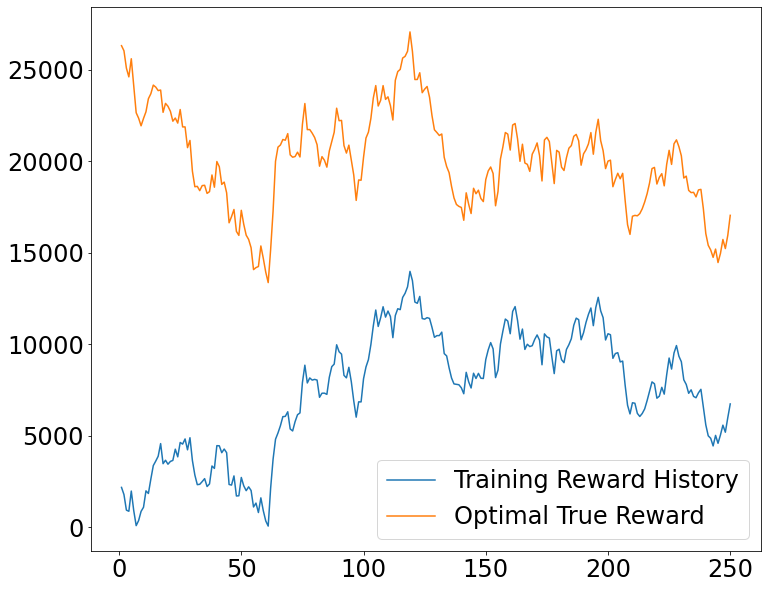

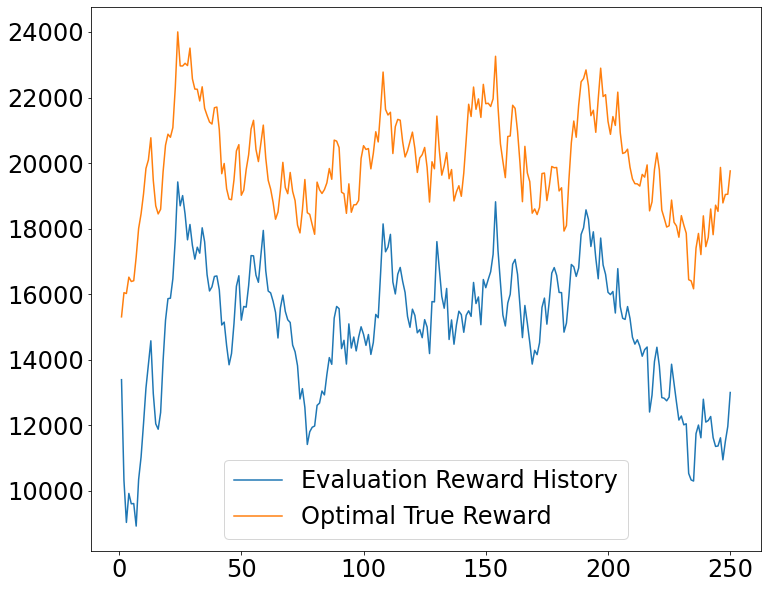

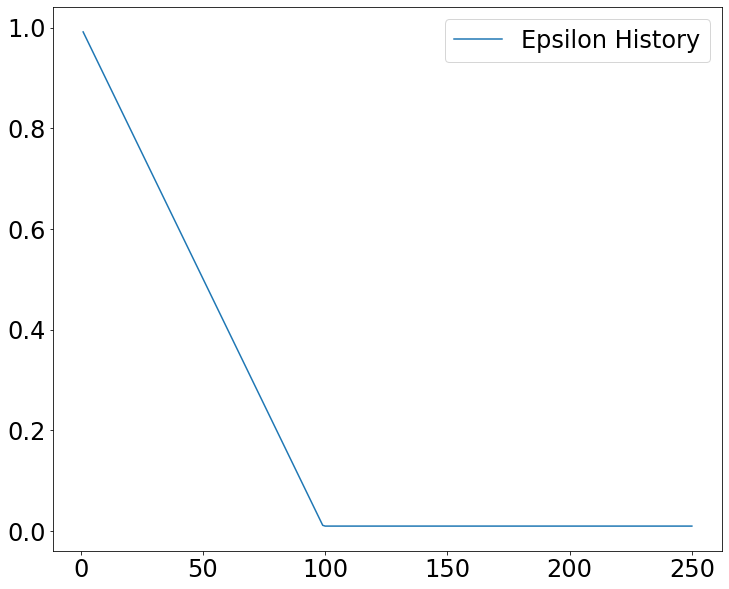

In [50]:
plt.figure(figsize=(12,10))
plt.plot(x, numpy_ewma_vectorized_v2(np.array(scores), 25), label='Training Reward History')
plt.plot(x, numpy_ewma_vectorized_v2(np.array(optimal_training_scores), 25), label='Optimal True Reward')
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
plt.plot(x, numpy_ewma_vectorized_v2(np.array(eval_scores), 25), label='Evaluation Reward History')
plt.plot(x, numpy_ewma_vectorized_v2(np.array(optimal_evaluation_scores), 25), label='Optimal True Reward')
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
plt.plot(x, eps_history, label='Epsilon History')
plt.legend()
plt.show()

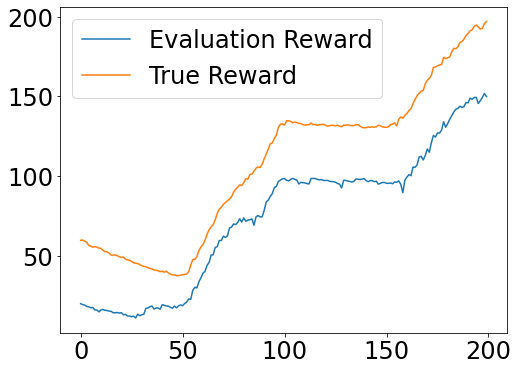

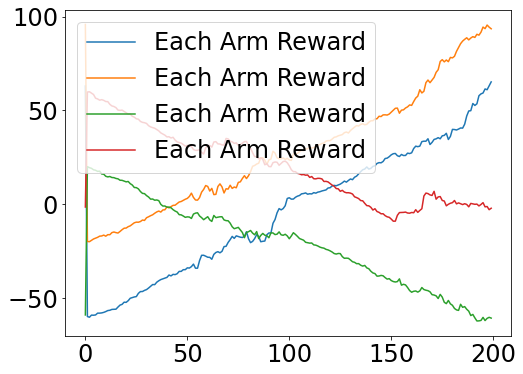

In [51]:
episodes = 100
import matplotlib.pyplot as plt
rew = np.zeros((episodes, 200, 4))
rewards = np.zeros((episodes, 200))
optimal_action = np.zeros((episodes, 200))
regret = np.zeros((episodes, 200))
optimal_reward = np.zeros((episodes, 200))
random_rewards = np.zeros((episodes, 200))
env = fourarmedbandit(seed=SEED, trend=True, high=True)
obs = env.reset()
# env.set_seed(0)
dones = False
# np.random.seed(0)
# T.manual_seed(0)
for i in range(episodes):
  obs = env.reset()
  dones = False
  optim = 0
  while not dones:
      # action, _states = model.predict(obs)
      obs = obs.flatten()
      state = T.tensor([obs]).to(agent.Q_eval.device).float() # need to turn observation into pytorch tensor and send it to the device
      actions = agent.Q_eval.forward(state)
      action = T.argmax(actions).item()
      # opt = env.optm
      # vstar = env.reward_space[opt]
      e = env.e
      rew[i][e][:] = env.rewards
      random_action = np.random.choice(4)
      random_rewards[i][e] = env.rewards[random_action]
      obs, rewards[i][e], dones, info = env.step(action)
      optimal_reward[i][e] = env.optm
      # if e == 0:
      #     regret[i][e] = v_star - Q[e]
      # else:
      #     regret[i][e] = regret[e - 1] + v_star - Q[a]
      # if action == opt:
      #     optim += 1
      # optimal_action[i][e] = (optim/(e + 1))*100


plt.figure(figsize=(8,6))
plt.plot(np.mean(rewards, axis = 0), label='Evaluation Reward')
plt.plot(np.mean(optimal_reward, axis = 0), label='True Reward')
# plt.plot(np.mean(random_rewards, axis = 0), label='Random Scheme')
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
plt.plot(np.mean(rew, axis = 0), label='Each Arm Reward')
plt.legend()
plt.show()
# plt.plot(np.mean(optimal_action, axis = 0))